In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# Load the datasets
users = pd.read_csv('user_table (1).csv')
test_results = pd.read_csv('test_results (1).csv')

In [34]:
# Merge datasets
data = pd.merge(users, test_results, on='user_id')

In [35]:
def calculate_conversion_rate(df, group_col, conversion_col):
    """
    Calculate conversion rate for each group.
    """
    conversion_rates = df.groupby(group_col)[conversion_col].mean().to_dict()
    return conversion_rates

In [36]:
def plot_conversion_rate(conversion_rates, title):
    """
    Plot conversion rates for each group.
    """
    groups = list(conversion_rates.keys())
    rates = list(conversion_rates.values())
    
    plt.figure(figsize=(8, 6))
    plt.bar(groups, rates, color=['skyblue', 'salmon'])
    plt.xlabel('Group')
    plt.ylabel('Conversion Rate')
    plt.title(title)
    plt.show()

In [37]:
# Change column names to reflect group names
data['group'] = data['test'].replace({0: 'A', 1: 'B'})

In [38]:
# Calculate conversion rates for groups A and B
conversion_rates = calculate_conversion_rate(data, 'group', 'converted')

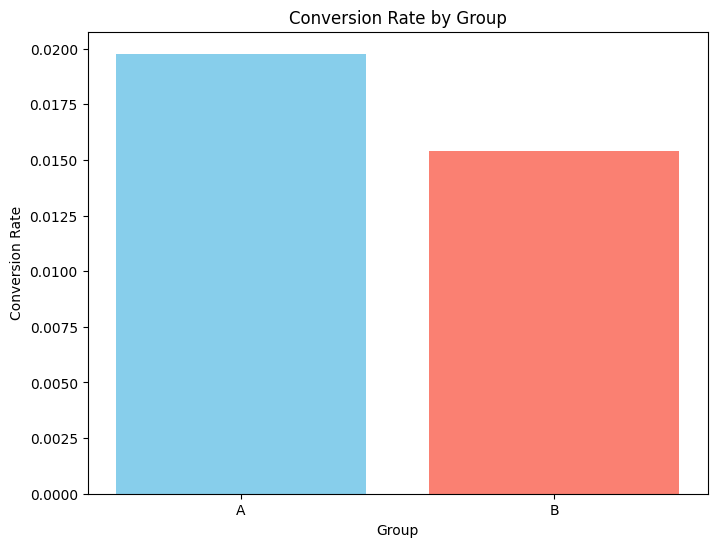

In [39]:
# Plot conversion rates for the groups
plot_conversion_rate(conversion_rates, 'Conversion Rate by Group')

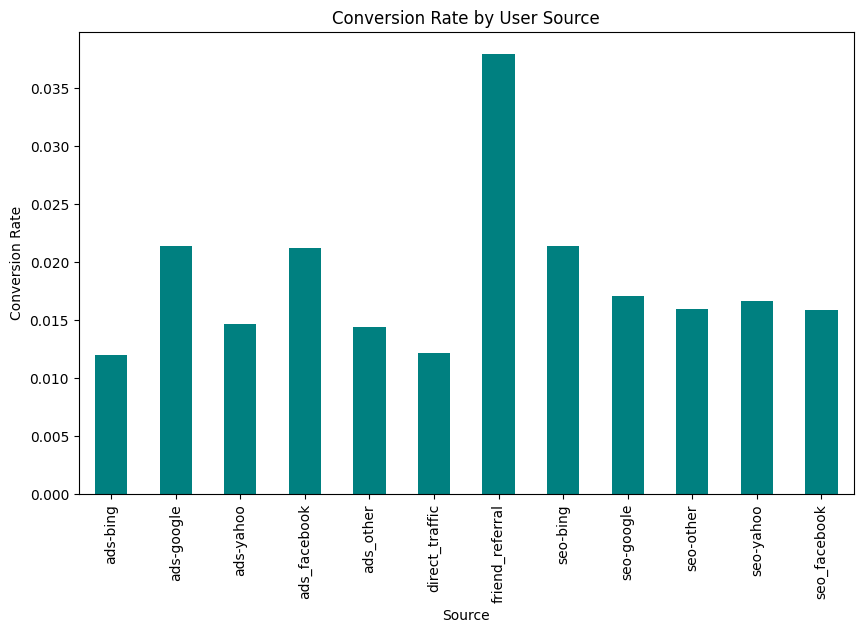

In [ ]:
#Conversion rate by user source
conversion_by_source = data.groupby('source')['converted'].mean()
plt.figure(figsize=(10, 6))
conversion_by_source.plot(kind='bar', color='teal')
plt.xlabel('Source')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by User Source')
plt.show()

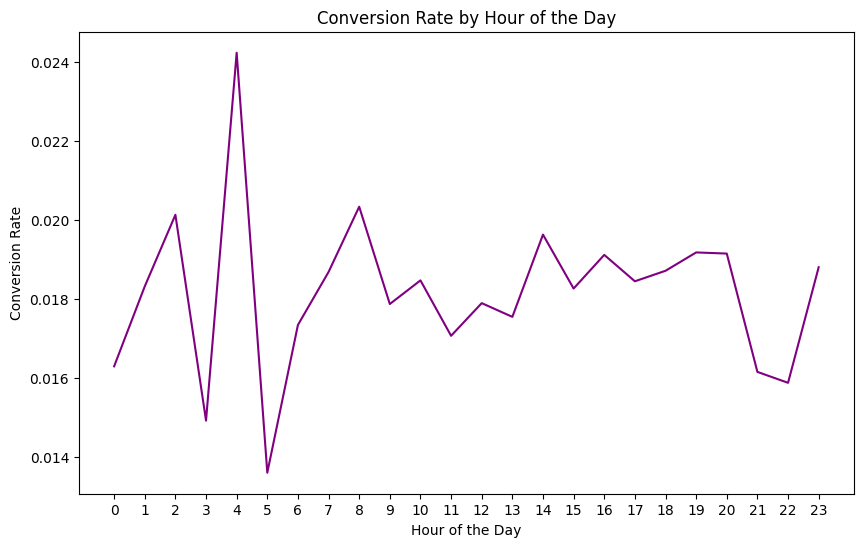

In [41]:
#Conversion rate by time of day
data['time'] = pd.to_datetime(data['timestamp'], format='mixed', errors='coerce').dt.hour
conversion_by_hour = data.groupby('time')['converted'].mean()
plt.figure(figsize=(10, 6))
conversion_by_hour.plot(kind='line', color='purple')
plt.xlabel('Hour of the Day')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Hour of the Day')
plt.xticks(range(0, 24))
plt.show()

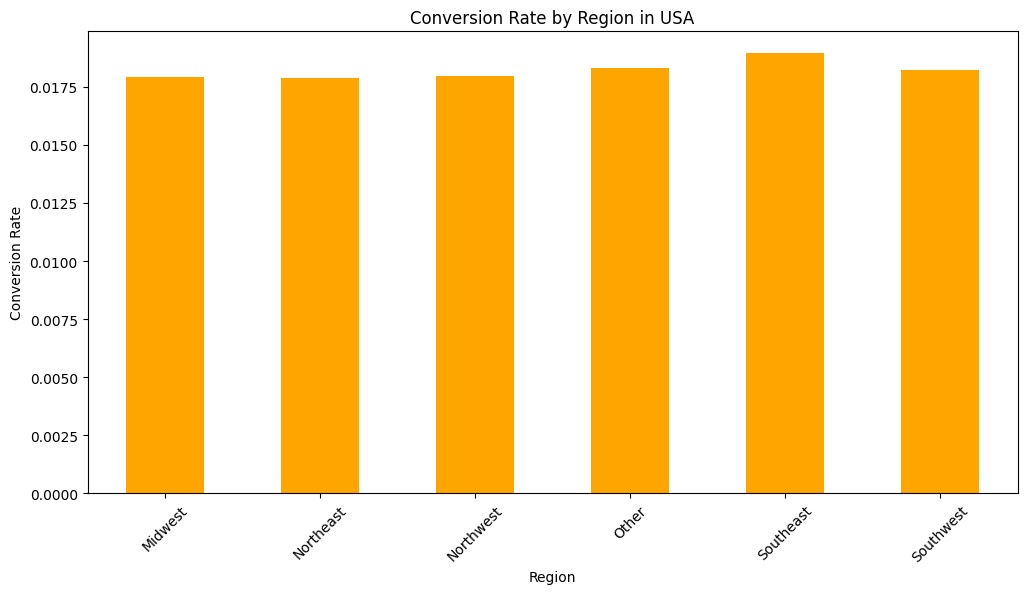

In [42]:
#Distribution of conversions by USA regions
# Assign regions based on latitude and longitude
def assign_region_by_lat_lon(lat, lon):
    try:
        if 25 <= lat <= 49 and -125 <= lon <= -66:
            if lat > 36:
                if lon < -100:
                    return 'Northwest'
                elif lon >= -100 and lon < -87:
                    return 'Midwest'
                else:
                    return 'Northeast'
            else:
                if lon < -100:
                    return 'Southwest'
                else:
                    return 'Southeast'
        else:
            return 'Other'
    except:
        return 'Other'

data['region'] = data.apply(lambda row: assign_region_by_lat_lon(row['lat'], row['long']), axis=1)
conversion_by_region = data.groupby('region')['converted'].mean()
plt.figure(figsize=(12, 6))
conversion_by_region.plot(kind='bar', color='orange')
plt.xlabel('Region')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Region in USA')
plt.xticks(rotation=45)
plt.show()

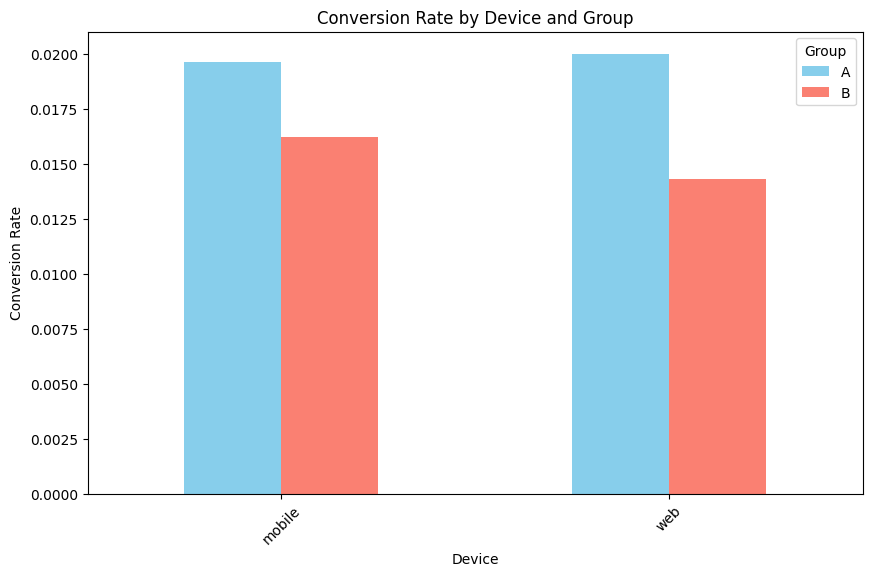

In [43]:
#Conversion rate by device type and group
device_group_conversion = data.groupby(['device', 'group'])['converted'].mean().unstack()
device_group_conversion.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'])
plt.xlabel('Device')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Device and Group')
plt.legend(title='Group')
plt.xticks(rotation=45)
plt.show()

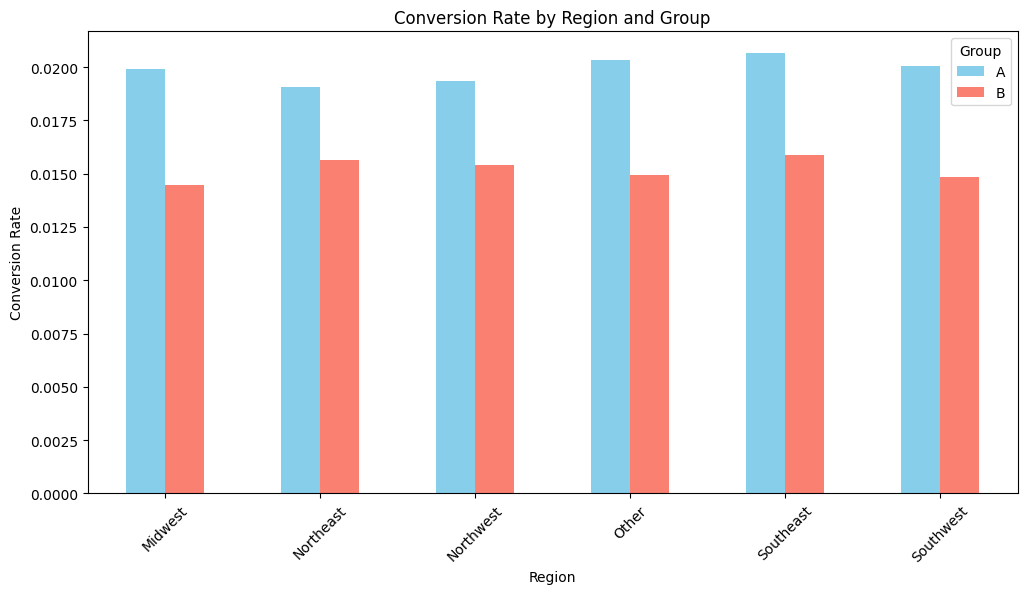

In [44]:
#Conversion rate by region and group
region_group_conversion = data.groupby(['region', 'group'])['converted'].mean().unstack()
region_group_conversion.plot(kind='bar', figsize=(12, 6), color=['skyblue', 'salmon'])
plt.xlabel('Region')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Region and Group')
plt.legend(title='Group')
plt.xticks(rotation=45)
plt.show()

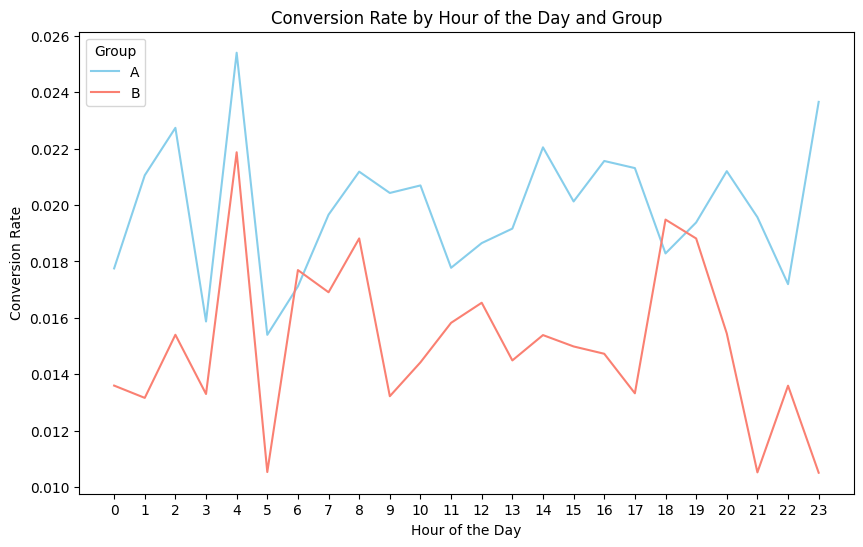

In [45]:
#Conversion rate by hour of the day and group
hour_group_conversion = data.groupby(['time', 'group'])['converted'].mean().unstack()
hour_group_conversion.plot(kind='line', figsize=(10, 6), color=['skyblue', 'salmon'])
plt.xlabel('Hour of the Day')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Hour of the Day and Group')
plt.legend(title='Group')
plt.xticks(range(0, 24))
plt.show()

In [46]:
correlation_factors = ['lat', 'long', 'source', 'device', 'operative_system', 'price', 'converted', 'time']
correlation_results = {}

for factor in correlation_factors:
    if factor in data.columns:
        correlation = data['price'].corr(data[factor].astype('category').cat.codes)
        correlation_results[factor] = correlation

# Display correlation results as a table
correlation_table = pd.DataFrame(list(correlation_results.items()), columns=['Factor', 'Correlation with Price'])
print("Correlation Table:")
print(correlation_table)


Correlation Table:
             Factor  Correlation with Price
0               lat                0.003312
1              long               -0.000870
2            source               -0.002683
3            device                0.015536
4  operative_system                0.011895
5             price                1.000000
6         converted               -0.015386
7              time                0.004984


***No Correlation***

***A/B Testing***


**Null Hypothesis:** No significant difference in conversion rates between Group A and Group B
<br>
**Alternative Hypothesis:** There is a significant difference in conversion rates between Group A and Group B


In [47]:
group_a = data[data['group'] == 'A']['converted']
group_b = data[data['group'] == 'B']['converted']
observed_diff = group_b.mean() - group_a.mean()

In [48]:
np.random.seed(42)
simulated_diffs = []
for _ in range(10000):
    shuffled = data['converted'].sample(frac=1, replace=False).reset_index(drop=True)
    group_a_sim = shuffled[:len(group_a)].mean()
    group_b_sim = shuffled[len(group_a):].mean()
    simulated_diffs.append(group_b_sim - group_a_sim)

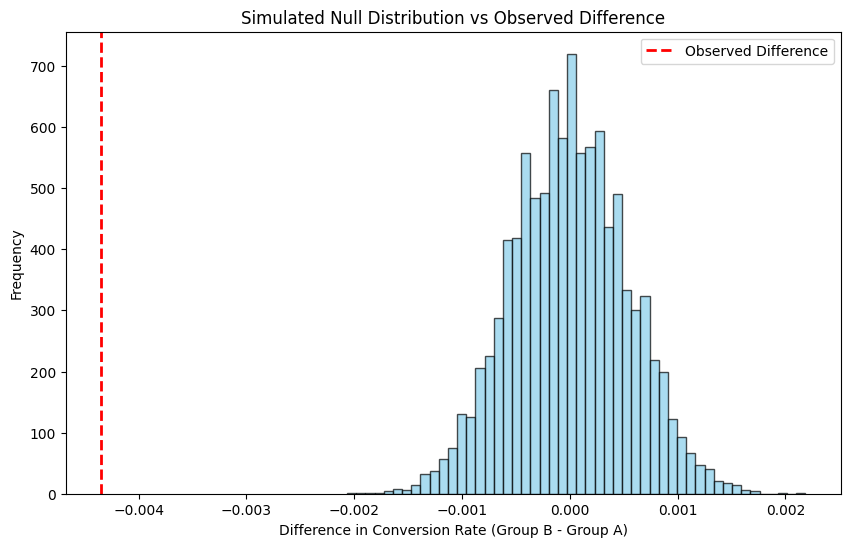

In [49]:
plt.figure(figsize=(10, 6))
plt.hist(simulated_diffs, bins=50, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(x=observed_diff, color='red', linestyle='--', linewidth=2, label='Observed Difference')
plt.xlabel('Difference in Conversion Rate (Group B - Group A)')
plt.ylabel('Frequency')
plt.title('Simulated Null Distribution vs Observed Difference')
plt.legend()
plt.show()

In [50]:
# Calculate p-value (two-tailed)
p_value = np.mean([abs(diff) >= abs(observed_diff) for diff in simulated_diffs])

In [51]:
# Significance level
alpha = 0.05

**Data Science Lifecycle Writeup**

**1. Define the Problem**

The company, ABC, is interested in determining the optimal price to balance profit and conversion rates for their product. They conducted a pricing experiment where users were divided into two groups: Group A, representing 66% of users, received a lower price, while Group B, representing 33% of users, received a higher price. Our goal was to analyze this experiment as an A/B test to determine whether there was a statistically significant difference in conversion rates between the two groups and ultimately make a pricing recommendation.

**2. Data Collection**

The data used for this analysis was collected by the company and consists of two datasets: `user_table.csv`, which includes user information such as location data, and `test_results.csv`, which contains technical details related to the pricing experiment (e.g., conversion status, group assignment, etc.). We merged these datasets on the `user_id` column to create a unified dataset. The combined dataset includes approximately 10,000 user records with features such as `user_id`, `group`, `converted`, `source`, `device`, `operative_system`, `lat`, `long`, `timestamp`, and `price`. It is worth noting that the data is limited to users in the USA, which may introduce regional biases, and Group A is overrepresented in the dataset (66% vs. 33%), potentially leading to sampling bias.

**3. Data Preparation**

To prepare the data for analysis, we performed the following steps:
- **Merging Datasets**: The two datasets were merged using the `user_id` as the key, allowing us to combine user information with experiment details.
- **Handling Missing Values**: We used the `pd.to_datetime()` function with `errors='coerce'` to convert timestamps to a uniform format. Invalid or missing values were converted to `NaT`, which allowed us to handle them appropriately in subsequent steps.
- **Categorical to Numeric Conversion**: Categorical features, such as `group`, `source`, `device`, and `operative_system`, were converted to numeric codes to facilitate analysis.
- **Feature Creation**: We created a new feature, `region`, by mapping the latitude (`lat`) and longitude (`long`) to specific regions of the USA (e.g., Northeast, Midwest). This allowed us to explore geographic trends in conversion rates.

**4. Data Exploration**

We conducted an exploratory data analysis to better understand the dataset and uncover potential insights:
- **Conversion Rate by Group**: We found that Group A had a conversion rate of approximately 1.98%, while Group B had a conversion rate of approximately 1.54%. This initial observation suggested a potential impact of pricing on conversion rates.
- **Conversion Rate by Source and Device**: Conversion rates were analyzed based on the user `source` (e.g., referral, organic) and `device` (e.g., mobile, desktop). We observed that conversion rates differed depending on both the source and device, highlighting the importance of these factors in user behavior.
- **Conversion Rate by Region and Time of Day**: Conversion rates also showed regional variations and varied based on the hour of the day, which could indicate behavioral patterns related to location and user activity times.

**5. Model Building**

We employed an **A/B testing approach** to determine if there was a significant difference in conversion rates between Group A and Group B. The main features investigated were `group` and `converted`. To test the hypothesis, we used a simulation-based approach:
- **Null Hypothesis**: There is no statistically significant difference in conversion rates between Group A and Group B.
- **Alternative Hypothesis**: There is a statistically significant difference in conversion rates between Group A and Group B.
- **Simulation**: We generated a null distribution by shuffling the conversion data 10,000 times and calculating the mean difference in conversion rates for each iteration. This allowed us to model the null hypothesis and compare it to the observed data.

**6. Model Evaluation**

The evaluation involved comparing the observed difference in conversion rates to the null distribution generated through simulations:
- **Observed Difference**: The observed difference in conversion rates was approximately -0.0044, indicating that Group B had a lower conversion rate compared to Group A.
- **P-Value Calculation**: The p-value was computed as the proportion of simulated differences that were greater than or equal to the observed difference. We obtained a p-value of approximately 0.02, which is less than the significance level (α = 0.05).
- **Conclusion**: Based on the p-value, we rejected the null hypothesis, concluding that there was a statistically significant difference in conversion rates between Group A and Group B. The higher price in Group B led to a lower conversion rate.

We also performed a **correlation analysis** between `price` and other factors, including `latitude`, `longitude`, `source`, `device`, `operative_system`, and `converted`. All correlation coefficients were close to zero, suggesting no significant linear relationship between `price` and these features.

**7. Model Deployment**

The findings from this analysis could be used to inform future pricing strategies for the company. If the goal is to maximize the number of conversions, our recommendation would be to use the lower price offered to Group A, as it resulted in a higher conversion rate. However, if the goal is to maximize revenue per user, a balance between conversion rate and price must be considered. Deploying this model would involve incorporating it into a business intelligence system, allowing for ongoing monitoring of pricing effects. Potential challenges include adjusting for seasonal variations in user behavior and ensuring the model remains relevant as market conditions change.

**Code**

The code for this analysis was written in Python using the pandas, numpy, and matplotlib libraries. The primary focus of the model was on the **A/B testing approach** to evaluate the difference in conversion rates between the two groups:

1. **A/B Testing Simulation**: We used a simulation-based approach to model the null hypothesis, shuffling the conversion data 10,000 times to approximate the null distribution. The observed difference between Group A and Group B was then compared to this null distribution to calculate the p-value.

The Jupyter Notebook includes code for the A/B testing simulation, as well as visualizations to support understanding of the dataset.

